In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

2025-01-05 22:59:09.829047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 22:59:09.848735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736114349.863894 1433173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736114349.868515 1433173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 22:59:09.884737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Define the file paths
subdirectory = "pickle_data_Kuchen"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1462, 31)
Loaded Validation features dimensions: (357, 31)
Loaded Test features dimensions: (355, 31)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Temp_Warm_current  \
7223                  0                  1                  0   
7224                  0                  1                  0   
7225                  0                  0                  1   
7226                  0                  1                  0   
7227                  0                  1                  0   

      Temp_Hot_current  Cloud_ok_current  Cloud_Cloudy_current  \
7223                 0                 0                     1   
7224                 0                 1                     0   
7225                 0                 0                     1   
7226                 0                 0                     1   
72

In [3]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.1),
    Dense(50, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),
    Dropout(0.15),
    Dense(25, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),

    Dense(1)
])

model.summary()

I0000 00:00:1736114351.716791 1433173 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 973 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.003, durch den lr_scheduler geregelt
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=500,
    batch_size=8,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/500


I0000 00:00:1736114353.689269 1454050 service.cc:148] XLA service 0x7f368c004b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736114353.689309 1454050 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-05 22:59:13.705825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736114353.770266 1454050 cuda_dnn.cc:529] Loaded cuDNN version 90300


 49/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 285.0958 - mape: 99.7149

I0000 00:00:1736114355.133934 1454050 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 244.0836 - mape: 85.1151 - val_loss: 49.9986 - val_mape: 19.7213 - learning_rate: 0.0010
Epoch 2/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.8772 - mape: 17.9209 - val_loss: 51.4232 - val_mape: 20.2945 - learning_rate: 0.0010
Epoch 3/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 57.7569 - mape: 17.1827 - val_loss: 42.4083 - val_mape: 15.2884 - learning_rate: 0.0010
Epoch 4/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 48.7549 - mape: 16.1753 - val_loss: 48.9993 - val_mape: 16.3513 - learning_rate: 0.0010
Epoch 5/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 52.1858 - mape: 16.7578 - val_loss: 42.1919 - val_mape: 15.3036 - learning_rate: 0.0010
Epoch 6/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 48.7312 - mape: 16.1699 - val_loss: 41.6775 - val_mape: 14.2392 - learning_rate: 0.0010
Epoch 7/500
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46.1017 - mape: 15.1957 - val_loss: 44.2880 - val_mape:

In [5]:
# Saving the trained Model
model.save("python_model_Kuchen.h5")

In [6]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAPE on the Training Data: 13.26%
MAPE on the Validation Data: 13.88%


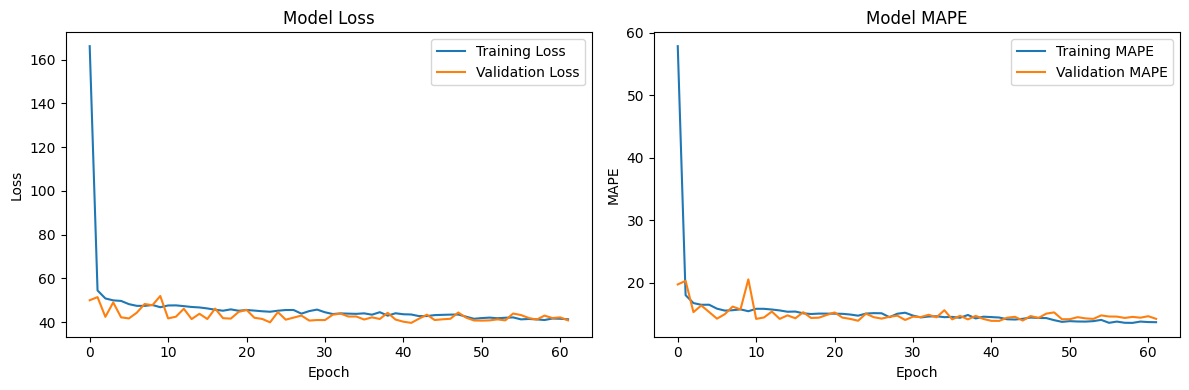

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


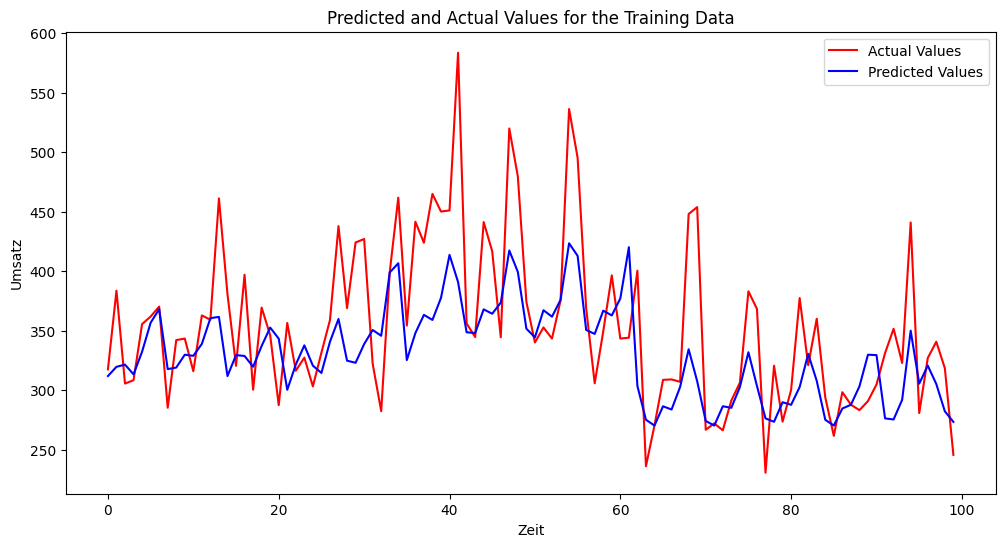

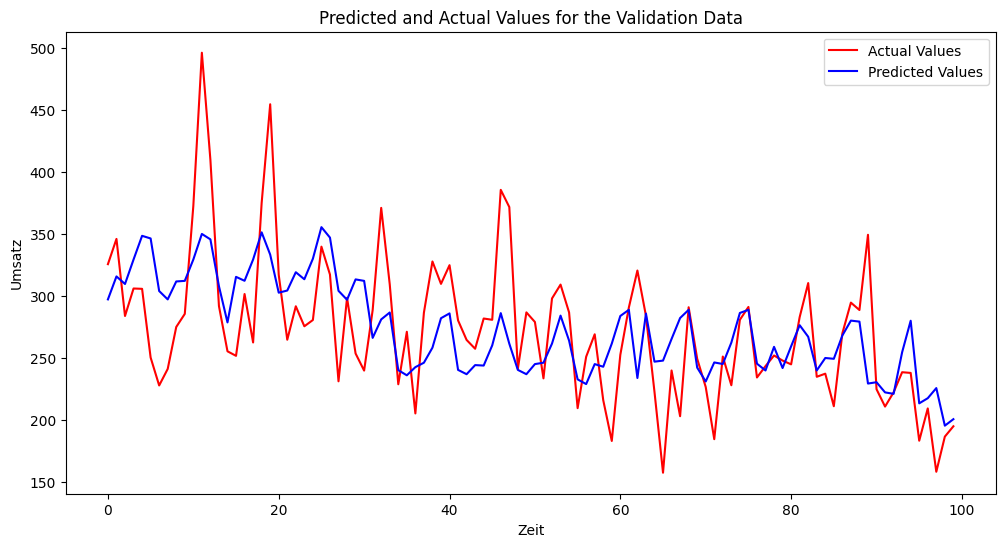

In [8]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [9]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Größe des Arrays (shape): (355, 1)


,0
0,292.725891
1,270.066071
2,285.069702
3,303.328674
4,310.788696
...,...
350,253.860092
351,281.181244
352,286.726898
353,233.537262


In [10]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_5"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
1419,1808015,2018-08-01,0,0,0,0,1,0,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,1.0,1,1.0,1.0
1420,1808025,2018-08-02,0,0,0,0,1,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
1421,1808035,2018-08-03,0,0,0,0,1,0,0,0.0,...,0.0,0.0,0.0,0.2,1,1.0,1.0,1,1.0,1.0
1422,1808045,2018-08-04,0,0,0,0,1,0,0,0.0,...,0.0,0.2,0.0,0.0,1,1.0,0.0,1,1.0,1.0
1423,1808055,2018-08-05,0,0,0,0,1,0,0,0.0,...,0.0,0.0,0.2,0.0,0,1.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,1907265,2019-07-26,0,0,0,0,1,0,0,0.0,...,0.0,0.0,0.2,0.6,1,0.0,1.0,1,1.0,0.0
1770,1907275,2019-07-27,0,0,0,0,1,0,0,0.0,...,0.0,0.6,0.0,0.4,1,1.0,1.0,0,1.0,1.0
1771,1907285,2019-07-28,0,0,0,0,1,0,0,0.0,...,0.0,0.4,0.6,0.2,1,1.0,0.0,1,0.0,1.0
1772,1907295,2019-07-29,0,0,0,0,1,0,0,0.0,...,0.0,0.2,0.4,0.2,0,1.0,0.0,1,1.0,1.0


In [11]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Kuchen_Hochladeformat.csv"

predictions_df.to_csv('Kuchen_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
